In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "darkgrid")

import gc

import keras
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, MaxPool2D, Conv2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import cv2

In [3]:
df_num = pd.read_csv("../input/mnist-in-csv/mnist_train.csv")
df_alph = pd.read_csv("../input/handwritten-data/A_Z Handwritten Data.csv")
df_alph["0"] += 10

In [4]:
df_num.shape, df_alph.shape

((60000, 785), (372450, 785))

In [5]:
df_num.head(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_alph.head(3)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
pixel_array = ["Label"]
for i in range(1, 785):
    pixel_array.append(f"pixel_{i}")
df_num.columns = pixel_array
df_alph.columns = pixel_array
del pixel_array
gc.collect()

76

In [8]:
df = pd.concat([df_num, df_alph], axis = 0)
df.shape

(432450, 785)

In [9]:
SEED = 42
np.random.seed(SEED)

Text(0.5, 1.0, 'Target value distribution')

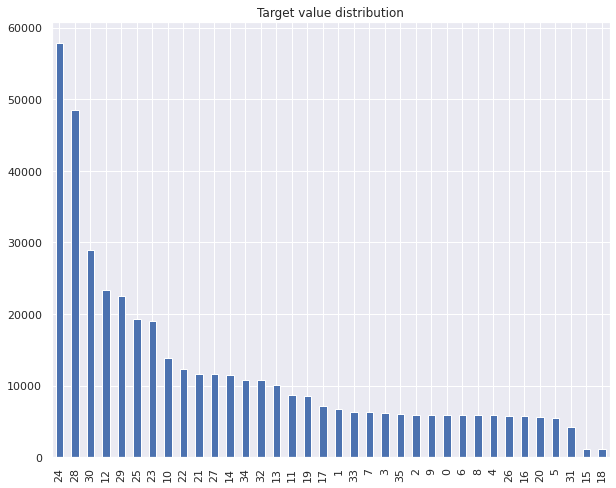

In [10]:
plt.rcParams["figure.figsize"] = [10, 8]
df.Label.value_counts().plot(kind = "bar")
plt.title("Target value distribution")

In [11]:
import time
def cleanup():
    gc.collect()
    time.sleep(10)

In [12]:
cleanup()

In [13]:
a, b = df.Label[df.Label == 24].value_counts().sum(), df.Label[df.Label == 18].value_counts().sum()
print(f"Maximum and Minimum frequency for any target value in the data: {a, b}")

Maximum and Minimum frequency for any target value in the data: (57825, 1120)


In [14]:
X = df.drop(["Label"], axis = 1)
y = df["Label"]
X.shape

(432450, 784)

In [15]:
X_reshaped = X.values.astype("float32").reshape(X.shape[0], 28, 28)
y_int = y.values.astype("int32")
print(X.shape, "***", X_reshaped.shape)

(432450, 784) *** (432450, 28, 28)


In [16]:
cleanup()

In [17]:
X_reshaped = X_reshaped.reshape(-1, 28, 28, 1)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_int, test_size = 0.3, stratify = y)

data_to_predict = X_test.reshape(-1, 28, 28)

In [18]:
def plot_grid(pred = False):
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        index = np.random.randint(data_to_predict.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(data_to_predict[index], cmap = plt.get_cmap("gray"))
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f"Label: {y_test[index]}")
    plt.tight_layout()
    plt.show()

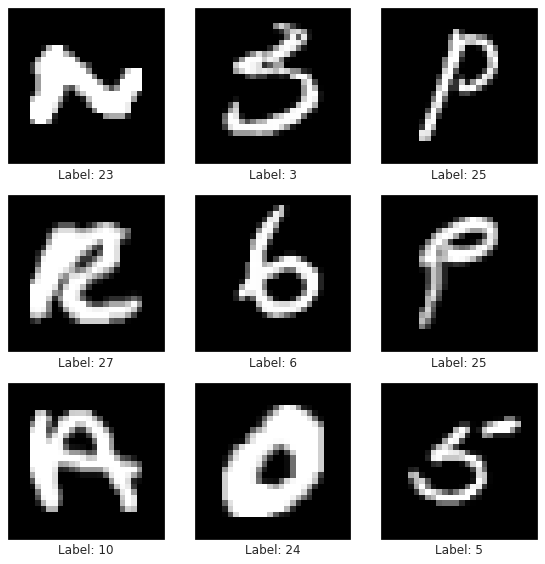

In [20]:
plot_grid()

In [21]:
X_train_mean = X_train.mean().astype(np.float32)
X_train_std = X_train.std().astype(np.float32)
X_test_mean = X_test.mean().astype(np.float32)
X_test_std = X_test.std().astype(np.float32)

X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_test_mean)/X_test_std

y_train = to_categorical(y_train, num_classes = 36)
y_test = to_categorical(y_test, num_classes = 36)

In [22]:
del X_train_mean, X_train_std, df_num, df_alph, X_reshaped, y_int, X, y, X_test_mean, X_test_std, data_to_predict, a, b
gc.collect()

27194

In [23]:
input_shape = (28, 28, 1)
num_classes = 36

model = Sequential()
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "Same", input_shape = input_shape))
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(150, activation = "relu"))
model.add(Dropout(0.30))
model.add(Dense(36, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0

In [24]:
optimizer = Adam(lr = .0005, beta_1 = .9, beta_2 = .999, epsilon = 1e-07, decay = 0, amsgrad = False)

In [25]:
# Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["categorical_accuracy", tf.keras.metrics.AUC()])

# learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = .5, min_lr = .00001)

# EarlyStopping
es = EarlyStopping(monitor='val_categorical_accuracy', patience = 4)

In [26]:
epochs = 80
batch_size = 128

In [27]:
# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = False, 
                            featurewise_std_normalization = False, samplewise_std_normalization = False,
                            zca_whitening = False, rotation_range = 10, zoom_range = .1, 
                            width_shift_range = .1, height_shift_range = .1, horizontal_flip = True, 
                            vertical_flip = False)
train_batches = datagen.flow(X_train, y_train, batch_size = batch_size)
val_batches = datagen.flow(X_test, y_test, batch_size = batch_size)

In [28]:
# Fitting the model
history = model.fit_generator(generator = train_batches, steps_per_epoch = train_batches.n//batch_size, epochs=epochs, 
                    validation_data = val_batches, validation_steps = val_batches.n//batch_size, verbose = 0,
                    callbacks = [learning_rate_reduction, es])

In [29]:
model.save("model_0-10_a-z.h5")

In [30]:
print(f"Total number of epochs for which the model trained: {len(history.history['loss'])}")

Total number of epochs for which the model trained: 35


Text(0, 0.5, 'Accuracy')

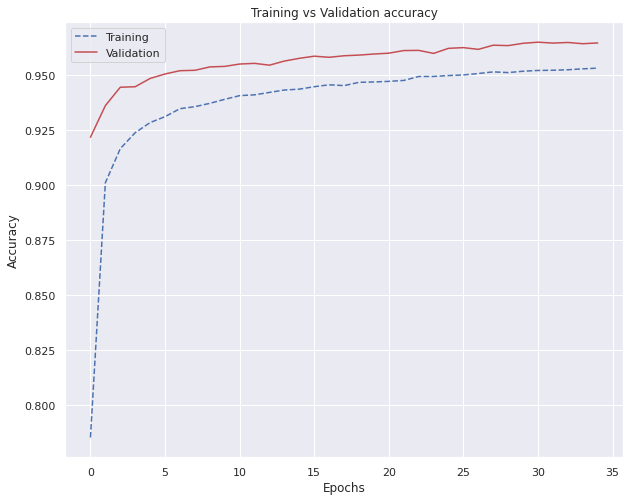

In [31]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['categorical_accuracy'], "b--")
plt.plot(history.history['val_categorical_accuracy'], "r-")
plt.title("Training vs Validation accuracy")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [32]:
print(f"Maximum Training Accuracy: {max(history.history['categorical_accuracy'])}, Maximum Validation Accuracy: {max(history.history['val_categorical_accuracy'])}")

Maximum Training Accuracy: 0.9533357620239258, Maximum Validation Accuracy: 0.965140700340271


Text(0, 0.5, 'AUC score')

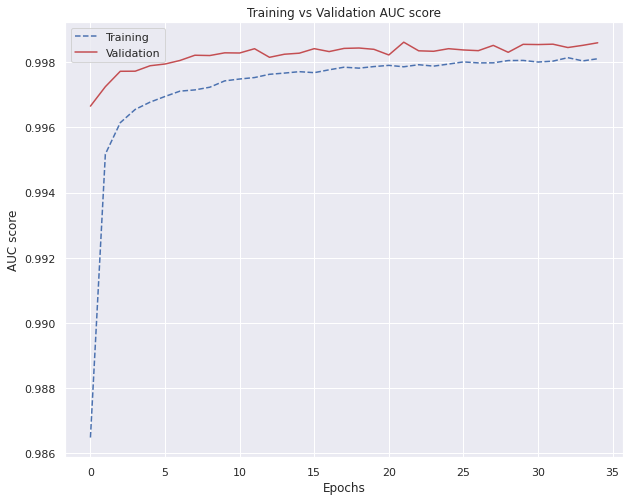

In [33]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['auc'], "b--")
plt.plot(history.history['val_auc'], "r-")
plt.title("Training vs Validation AUC score")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("AUC score")

In [34]:
print(f"Maximum Training AUC: {max(history.history['auc'])}, Maximum Validation AUC: {max(history.history['val_auc'])}")

Maximum Training AUC: 0.9981431365013123, Maximum Validation AUC: 0.9986189007759094


Text(0, 0.5, 'Loss value')

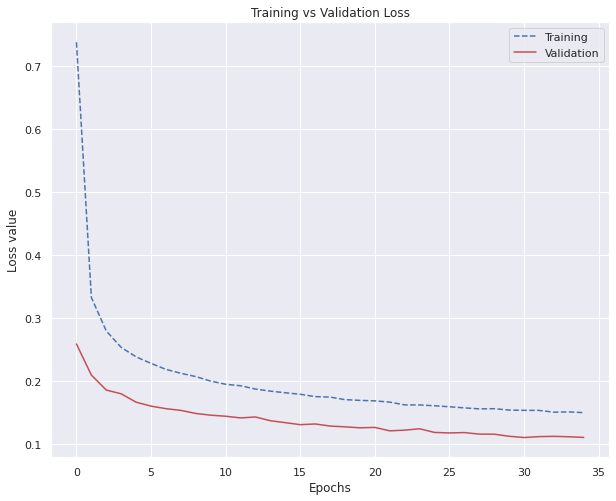

In [35]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['loss'], "b--")
plt.plot(history.history['val_loss'], "r-")
plt.title("Training vs Validation Loss")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")